In [116]:
# Script para contar o número de ciclones formados na costa leste da América do Sul

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr
import cartopy.crs as ccrs
import cartopy as cart
import harmonica as hm
from scipy import interpolate
#

print('Hello Storms!')

Hello Storms!


In [117]:
# Definição de parâmetros
#=====================
# Anos que serão analizados
# Os arquivos estão ordenados por ANO e MES. Utilizarei isso para percorrer todos os arquivos
anoi=1980
anof=2011

#============
# A cada ponto de grade (ponto [i,j]) o programa verifica se aquele ponto contém o 
# menor valor de vorticidade relativa, comparado aos seus vizinhos. Essa comparação
# ocorre numa caixa definida entre:
# em x: i - delx_box: i + delx_box+1  
# em y: j - dely_box: j + dely_box +1
delx_box=4
dely_box=4

#============
# Uma vez encontrado um ponto de mínima vorticidade relativa, o programa verifica se aquele
# ponto atinge o critério de corte. Se ultrapassar, será considerado um ciclone. Esse critério
# utiliza os valores do ponto de mínima e os valores de seus vizinhos. Os parametros
# delx_cy e dely_cy controlam o tamanho da caixa que engloba os pontos vizinhos. Essa caixa pode
# ser diferente da caixa definida anteriormente.
delx_cy=4
dely_cy=4


#=========
delP_min=400.0       # Valor crítico de pressão [Pa] para ser considerado um ciclone
delVort_min=-1.5e-5  # VALOR crítico de vorticidade para ser considerado um ciclone 

# Usualmente utiliza-se a vorticidade como critério de detecção de ciclones. Contudo, 
# a pressão também pode ser utilizada. Esse script permite que voce utilize apenas a vorticidade,
# apenas a pressão ou ambos os critérios.
Pressure=''  # 'P' or '' para habilitar ou desabilitar a detecção pelo critério de pressão
Vorticity='V' # 'V' or '' para habilitar ou desabilitar a detecção pelo critério de pressão


ENSOfiltering = '' # 'EnsoFilter' or '' para habilitar ou desabilitar o filtro de casos ativos de ENSO
ONImax = 1         # Caso 'EnsoFilter' é utilizado, este é o valor crítico do Ocean Nino Index,
                   # acima do qual não se realiza a detecção

#=========================================================
# Area de interesse é definida pelos limites em termos de latitude e longitude.
# Estes valores são depois convertidos em pontos de grade
#
#        lat_end ---+________+---
#                   |        |
#                   |        |
#                   |        |
#      lat_start ---+________+---
#                   |        |
#            lon_start      lon_end
#
# 
lon_start=-61
lon_end=-39
lat_start=-43
lat_end=-24

# Aqui encontro os índices referentes às coordenadas LAT e LON definidas acima, que delimitarão o 
# domínio de análise. O domínio de análise deve sempre ser menor que o dominio total dos dados,
# deixando uma borda de no mínimo delx_box ou dely_box, em sua respectiva dimensão, para que 
# tenhamos pontos de grades vizinhos ao ponto de grade de interesse

def grid_offset():
    ixi=min(range(len(lon)), key=lambda i: abs(lon[i]-lon_start)) # find index of longitude nereast to 69W
    ixf=min(range(len(lon)), key=lambda i: abs(lon[i]-lon_end)) # find index of longitude nereast to 35W
    jyi=min(range(len(lat)), key=lambda i: abs(lat[i]-lat_start)) # find index of latitude nereast to 54S
    jyf=min(range(len(lat)), key=lambda i: abs(lat[i]-lat_end)) # find index of latitude nereast to 20S
    return ixi,ixf,jyi,jyf

    

In [118]:
# Abro arquivo de topografia. Utilizo esses dados para filtrar qualquer ciclones sobre o continente,
# uma vez que os ciclones serão detectados apenas sobre o oceano. Caso deseje detectar ciclogenese sobre o 
# continente, deverá observar se feições topográficas acarretam detecções falsas.
data = hm.datasets.fetch_topography_earth()


# Leio os arquivos que contém a pressão em superfície reduzida ao nível do mar 
# e a vorticidade relativa. Dados estão disponíveis a cada 6 horas (00, 06, 12 e 18 UTC)
def openc_getvar(mes):
    pnc= xr.open_dataset('data/prmsl.l.gdas.'+str(ano)+str(mes)+'.grb2.nc')
    vnc= xr.open_dataset('data/vort.'+str(ano)+str(mes)+'.nc')
    vort=vnc['VORT'][:]#[jyi:jyf]    
    slp=pnc['PRMSL_L101'][:]#[it,jyi:jyf,ixi:ixf]
    return slp,vort


# Leio os vetores com Latitude e Longitude
def openc_getCoord(mes):
    nc= xr.open_dataset('data/vort.'+str(ano)+str(mes)+'.nc')
    lat=nc.coords['LAT']#[jyi:jyf]
    lons=nc.coords['LON']#[ixi:ixf]
    lon=np.empty(len(lons))
    lon[0:72]=lons[72:144]-360
    lon[72:144]=lons[0:72]
    return lat,lon
  
# Leio um arquivo que contem o ONI mensal (ocean nino index). Utilizo (quando EnsoFiltering está ativado)
# esse dado como um filtro temporal, que selecionará apenas os meses com ONI abaixo de um certo critério
def ENSOmask():
    oni=xr.open_dataset('../ENSO_all_normalized.nc')
    std=np.std(oni.MED)
    oniMask=np.where(abs(oni.MED) > ONImax , 0 , 1)
    return oniMask,oni

# A grade do CFSR (NCEP em geral) tem inicio em LON=0 e vai até 360. 
# Faço um ajuste para que a grade comece em LON=-180 e vá até 180. Dessa forma o 
# oceano Atlântico, que é minha região de interesse, fica centrado na grade.
def adjustgrid():
    var1=np.empty([len(slp),len(lat),len(lon)])
    var1[:,:,0:72]=slp[:,:,72:144]
    var1[:,:,72:144]=slp[:,:,0:72]
    var2=np.empty([len(vort),len(lat),len(lon)])
    var2[:,:,0:72]=vort[:,:,72:144]
    var2[:,:,72:144]=vort[:,:,0:72]
    return var1,var2

In [119]:
# Encontra o ponto com menor pressão numa região (caixa) definida por dely_box e delx_box. 
def achaPmin(ic,jc):
    minimum=np.min(np.array(slp2[day,jc-dely_box:jc+dely_box+1,ic-delx_box:ic+delx_box+1]))
    jmin,imin = np.where(np.array(slp2[day,jc-dely_box:jc+dely_box+1,ic-delx_box:ic+delx_box+1]) == minimum)
    return int(imin[0]+ic-delx_box),int(jmin[0]+jc-dely_box)

# Encontra o ponto com menor vorticidade relativa numa caixa definida por dely_box e delx_box.
def achaVmin(ic,jc):
    minimum=np.min(np.array(vort2[day,jc-dely_box:jc+dely_box+1,ic-delx_box:ic+delx_box+1]))
    jmin,imin = np.where(np.array(vort2[day,jc-dely_box:jc+dely_box+1,ic-delx_box:ic+delx_box+1]) == minimum)
    return int(imin[0]+ic-delx_box),int(jmin[0]+jc-dely_box)


# Testo o ponto de mínima pressão para ver se este atende ao critério definido para ser classificado 
# como ciclone. Neste caso, determino que a diferença entre a pressão neste ponto e a média
# dos pontos vizinhos deve ser maior que um critério; 
def testp(imin,jmin):
    isP=False
    im2,jm2=achaPmin(imin,jmin)
    if im2==imin and jm2 ==jmin:
        pc=slp2[day,jmin,imin]
        pb=(slp2[day,jmin-dely_cy,imin-1:imin+2].mean() + slp2[day,jmin+dely_cy,imin-1:imin+2].mean()+
        slp2[day,jmin-1:jmin+2,imin-delx_cy].mean() + slp2[day,jmin-1:jmin+2,imin+delx_cy].mean())/4
        delp=pb-pc
        if float(delp) > delP_min :
            isP=True
    return isP

# Testo o ponto de mínima vorticidade relativa para ver se este atende ao critério definido para ser
# classificado como ciclone. Neste caso, a vorticidade relativa neste ponto deve ser menor que
# um critério limite estabelecido por delVort_min
def testv(imin,jmin):
    isV=False
    im2,jm2=achaVmin(imin,jmin)
    if im2==imin and jm2 ==jmin:
        if vort2[day,jmin,imin] <= delVort_min :
            isV=True
    return isV


# Aqui verifico se o ponto detectado é novo ou se já fora detectado anteriormente, dentro de uma
# caixa definida por dely_box e delx_box ao redor do ponto imin, jmin.
def isnew(imin,jmin):
    if cymap[day-1,jmin-dely_box:jmin+dely_box+1,imin-delx_box:imin+delx_box+1].sum() > 0:
        return False
    else:
        return True
        
        

In [120]:
# Interpolo a topografia para a grade Lat x Lon dos meus dados.
def masktopo():
    f = interpolate.interp2d(data.longitude, data.latitude, data.topography, kind='cubic')
    mmask=f(lon,lat)
    return mmask

# Essa função retorna o time-step de início e fim de cada mes, para cada ano;
def daysj(mes,key):
    if (ano % 4) == 0:
        if (ano % 100) == 0:
            if (ano % 400) == 0:
                feb=29
            else:
                feb=28
        else:
            feb=29
    else:
        feb=28

    dmes=np.array([0,31,feb,31,30,31,30,31,31,30,31,30,31])
    dia1=dmes[0:mes].sum()*4+1
    dia2=dmes[0:mes+1].sum()*4
    if key == 1:
        return dia1
    else:
        return dia2

#   
# Para cada dia do ano, encontra o índice da variável oniNeutro, que filtra meses com ENSO ativo.
def ONIindex():
    date = datetime.date(ano, 1, 1) #Will give 1996-01-01
    delta = datetime.timedelta(day/4) #str(delta) will be '31 days, 0:00:00'
    newdate = date + delta
    return newdate.strftime('%m')

    

In [121]:

# Antes do loop principal, vou iniciar algumas variáveis. 
ano=anoi # Defino um ano para obter os vetores de Lat e Lon
lat,lon=openc_getCoord('01') # Obtenho lat e lon
slp,vort=openc_getvar('01')  # obtenho pressao (slp) e vorticidade (vort) para saber suas dimensioes
slp2,vort2=adjustgrid()    # Ajusto a grade para começar com LON=-180.
oniNeutro,oni=ENSOmask()   # Obtenho oniNeutro, que retém apenas períodos com ENSO neutro



# interpolo a topografia para o lat lon obtido acima
mmask=masktopo() 

# Defino mapall, que contem o mapa de todos as posições dos cilones
# A estrutura é [anos, meses, lat, lon]
mapall=np.zeros([len(range(anoi,anof)),12,len(lat),len(lon)])

#===============================
# Inicio as posições do dominio de interesse
ixi,ixf,jyi,jyf=grid_offset()

# Essa lista será útil mais a frente
meses=['01','02','03','04','05','06','07','08','09','10','11','12']


In [122]:
# Finalmente, o loop principal!!
# A estrutura é um Loop nos ANOS, seguido por um loop nos Meses e, por fim
# dois loops para percorrer Latitude e Longitude.

for ano in range(anoi+1,anof,1):
    print('Opening year %i'%ano)
    for mes in range(0,len(meses)):
        slp,vort=openc_getvar(meses[mes]) # leio os dados de pressão e vorticidade
        slp2,vort2=adjustgrid()  # Ajusto a grade da pressão

        cymap=np.zeros(np.shape(slp))       # variável para armazenar o mapa dos cilcones em cada arquivo
        ciclogenese=np.zeros(np.shape(slp)) # variável para armazenar apenas os eventos de ciclogenese
    
        for day in range(0,len(vort2),1): # Note que o loop usa a variável day, mas o arquivo tem um 
                                          # time-step de 6horas. Cuidado p/ não cair na minha armadilha
            if oniNeutro[(ano-1980)*12+int(ONIindex())] == 1 or ENSOfiltering == '': # Se for filtrar ENSO
                                                                                     # só aceita
                                                                                     # oniNeutro==1
                for ix in range(min(ixi,ixf),max(ixi,ixf),1):  # A detecção ocorre num domínio menor,
                                                               # definido por ixi,ixf,jyi,jyf
                    for iy in range(min(jyi,jyf),max(jyi,jyf),1):
                        # note que podemos detectar o ciclone por dois critérios (pressao ou vorticidade)
                        # tratamos as detecções de forma independente

                        # primeiramente, vorticidade:
                        isv=False  # assume inicialmente que não atende ao critério de vorticidade 
                        if Vorticity == 'V': # verifica se vamos usar esse critério
                            iminv,jminv=achaVmin(ix,iy)
                            # agora verifico se já nao foi detectado ou se não está sobre o continente
                            if cymap[day,jminv,iminv] == 0 and mmask[jminv,iminv] < 0:
                                isv=testv(iminv,jminv)  
                                
                        # agora olhamos para o critério de pressão:
                        isp=False # assume inicialmente que não atende ao critério de vorticidade
                        if Pressure == 'P':
                            iminp,jminp=achaPmin(ix,iy)
                            # agora verifico se já nao foi detectado ou se não está sobre o continente
                            if cymap[day,jminp,iminp] == 0 and mmask[jminp,iminp] < 0:
                                isp=testp(iminp,jminp)  
                        
                        # Aqui vemos se esse passo resultou na detecção de um ciclone por algum
                        # dos métodos. Caso tenha sido detectado por ambos, será considerado
                        # um ponto intermediário entre os métodos
                        if isp == True and isv == False :
                            jp=jminp
                            ip=iminp
                        elif isp == False and isv == True :
                            jp=jminv
                            ip=iminv
                        elif isp == True and isv == True:
                            jp=int((jminv+jminp)/2)
                            ip=int((iminv+iminp)/2)
                    
                        if isp == True or isv == True:
                            cymap[day,jp,ip]=1
                            if isnew(ip,jp)== True :
                                # Note que atribuo o valor 1 a uma região em torno de ip,jp
                                # Um ciclone é contado apenas uma vez, mas ao invés de definirmos
                                # um único ponto de ciclogênese, definimos uma região .
                                ciclogenese[day,jp-1:jp+2,ip-1:ip+2]=1
                                      
    
        # Terminado de percorrer o arquivo .nc, atualizamos a contagem geral com
        # os ciclones detectados nesse arquivo
        mapall[ano-anoi,mes,::]+=ciclogenese[0:len(vort2),::].sum(axis=0)

        
print('Pronto!!')


Opening year 1981
Opening year 1982
Opening year 1983
Opening year 1984
Opening year 1985
Opening year 1986
Opening year 1987
Opening year 1988
Opening year 1989
Opening year 1990
Opening year 1991
Opening year 1992
Opening year 1993
Opening year 1994
Opening year 1995
Opening year 1996
Opening year 1997
Opening year 1998
Opening year 1999
Opening year 2000
Opening year 2001
Opening year 2002
Opening year 2003
Opening year 2004
Opening year 2005
Opening year 2006
Opening year 2007
Opening year 2008
Opening year 2009
Opening year 2010
Pronto!!


In [123]:
# Salvo os resultados para usar novamente
filename='cyclones_'+Pressure+Vorticity+'_SASD_'+ENSOfiltering+'.npy'
np.save(filename, mapall)

(31, 12, 73, 144)
101223.0


/home/wlademir/anaconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wlademir/anaconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


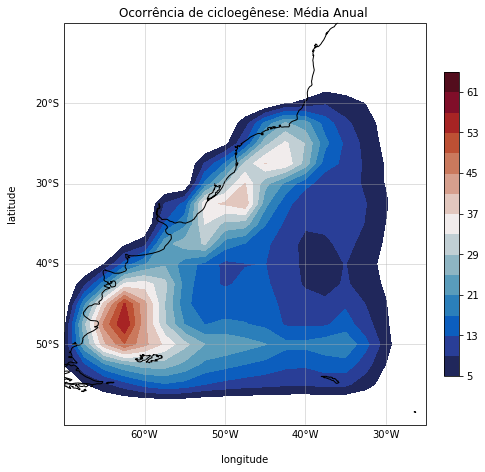

In [124]:
# Vamos dar uma olhada nos resultados!
import typhon
print(np.shape(mapall))
print(mapall.sum())
ciclones_all=mapall.sum(axis=(0,1))/(anof-anoi)


levs=np.linspace(5,65,16)
fig, ax1= plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(8,8))
cs1=ax1.contourf(lon,lat,ciclones_all,levels=levs,transform=ccrs.PlateCarree(),cmap='difference') #'PuOr')
ax1.set_extent([-70, -25, -60, -10], crs=ccrs.PlateCarree())
ax1.coastlines()
#ax1.add_feature(cart.feature.LAND, zorder=100,edgecolor='k')
ax1.set_title('Ocorrência de cicloegênese: Média Anual ')
ax1.text(-0.13, 0.55, 'latitude', va='bottom', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax1.transAxes)
#ax3.text(-0.19, 0.55, 'NOAA/NCEP Reanalys II', va='bottom', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax1.transAxes)
ax1.text(0.5, -0.1, 'longitude', va='bottom', ha='center',rotation='horizontal', rotation_mode='anchor',transform=ax1.transAxes)
gl = ax1.gridlines(draw_labels = True,alpha=0.5) # label all axes
gl.xlabels_top = False #turn off top label
gl.ylabels_right = False #turn off right label
cbar = fig.colorbar(cs1, ax=ax1, shrink=0.7, pad=0.04)


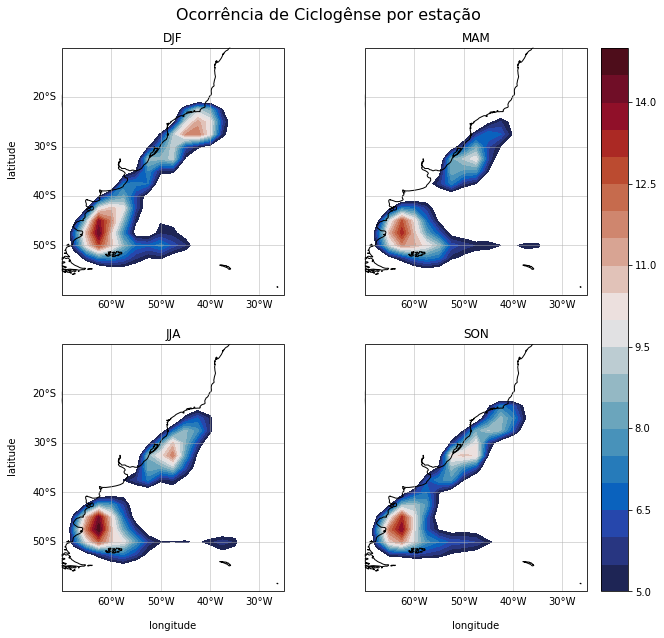

In [131]:
# Vamos olhar a variação sazonal do resultado

DJF=(mapall[:,0:2,::].sum(axis=(0,1))+mapall.sum(axis=0)[11,::])/(anof-anoi)
MAM=mapall[:,3:6,::].sum(axis=(0,1))/(anof-anoi)
JJA=mapall[:,5:8,::].sum(axis=(0,1))/(anof-anoi)
SON=mapall[:,8:11,::].sum(axis=(0,1))/(anof-anoi)

levs=np.linspace(5,15,21)

fig, ([ax1,ax2],[ax3,ax4])= plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},
                                         figsize=(12,10))
cs1=ax1.contourf(lon,lat,DJF,levels=levs,transform=ccrs.PlateCarree(),cmap='difference') #'PuOr')
ax1.set_extent([-70, -25, -60, -10], crs=ccrs.PlateCarree())
ax1.coastlines()
#ax1.add_feature(cart.feature.LAND, zorder=100,edgecolor='k')
ax1.set_title('DJF')
ax1.text(-0.2, 0.55, 'latitude', va='bottom', ha='center',rotation='vertical', rotation_mode='anchor',
         transform=ax1.transAxes)
ax1.text(1.2, 1.1, 'Ocorrência de Ciclogênse por estação', va='bottom', ha='center',rotation='horizontal',
         rotation_mode='anchor',transform=ax1.transAxes, fontsize=16)
gl = ax1.gridlines(draw_labels = True,alpha=0.6) # label all axes
gl.xlabels_top = False #turn off top label
gl.ylabels_right = False #turn off right label

cs2=ax2.contourf(lon,lat,MAM,levels=levs,transform=ccrs.PlateCarree(),cmap='difference') #'PuOr')
ax2.set_extent([-70, -25, -60, -10], crs=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_title('MAM')
gl = ax2.gridlines(draw_labels = True,alpha=0.6) # label all axes
gl.xlabels_top = False #turn off top label
gl.ylabels_right = False #turn off right label
gl.ylabels_left = False

cs3=ax3.contourf(lon,lat,JJA,levels=levs,transform=ccrs.PlateCarree(),cmap='difference') #'PuOr')
ax3.set_extent([-70, -25, -60, -10], crs=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_title('JJA')
ax3.text(-0.2, 0.55, 'latitude', va='bottom', ha='center',rotation='vertical', rotation_mode='anchor',
         transform=ax3.transAxes)
ax3.text(0.5, -0.16, 'longitude', va='bottom', ha='center',rotation='horizontal', rotation_mode='anchor',
         transform=ax3.transAxes)
gl = ax3.gridlines(draw_labels = True,alpha=0.6) # label all axes
gl.xlabels_top = False #turn off top label
gl.ylabels_right = False #turn off right label

cs4=ax4.contourf(lon,lat,SON,levels=levs,transform=ccrs.PlateCarree(),cmap='difference') #'PuOr')
ax4.set_extent([-70, -25, -60, -10], crs=ccrs.PlateCarree())
ax4.coastlines()
ax4.set_title('SON')
ax4.text(0.5, -0.16, 'longitude', va='bottom', ha='center',rotation='horizontal', rotation_mode='anchor',transform=ax4.transAxes)
gl = ax4.gridlines(draw_labels = True,alpha=0.6) # label all axes
gl.xlabels_top = False #turn off top label
gl.ylabels_right = False #turn off right label
gl.ylabels_left = False


cbar = fig.colorbar(cs1, ax=[ax1,ax2,ax3,ax4], shrink=1, pad=0.02)
#cbar = fig.colorbar(cs1, ax=ax4, shrink=0.8, pad=0.13)

